In [1]:
import cogsworth
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import gala.dynamics as gd
import gala.potential as gp
from gala.units import galactic
from scipy.integrate import cumulative_trapezoid
from astropy.coordinates import SkyCoord

/mnt/home/twagg/codes/gala/src/gala/potential/potential/builtin/special.py:193: GalaFutureWarning: In a future version of Gala, the current MilkyWayPotential and MilkyWayPotential2022 classes will be combined into a single class, MilkyWayPotential, with an optional 'version' argument to select between the models. To use the old (version 1) MilkyWayPotential, specify version="v1" when creating an instance. To use the newer (version 2 = current MilkyWayPotential2022), specify version="v2".
  warnings.warn(
/mnt/home/twagg/codes/gala/src/gala/potential/potential/builtin/special.py:257: GalaFutureWarning: The MilkyWayPotential2022 class will be deprecated soon. Instead, use: MilkyWayPotential(version="v2") to get what is currently the MilkyWayPotential2022 class. Or, to always use the latest Milky Way model in Gala, you can call the class with no arguments MilkyWayPotential() or specify MilkyWayPotential(version="latest")
  warnings.warn(


In [2]:
%config InlineBackend.figure_format = 'retina'


pd.options.display.max_columns = 999

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.9 * fs,
          'ytick.labelsize': 0.9 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

# Clustered near sun from Sanders & Binney

In [3]:
s = cogsworth.sfh.SandersBinney2015(10000, immediately_sample=True, potential=gp.MilkyWayPotential2022(), verbose=True)

Pre-computing lookback time, guiding radius and frequency interpolations
Initiating sampling procedure
  Sampling 8150 stars from the thin_disc
    Sampling 1010 stars with lookback times between 0.00 Gyr and 2.00 Gyr
    Sampling 1180 stars with lookback times between 2.00 Gyr and 4.00 Gyr
    Sampling 1588 stars with lookback times between 4.00 Gyr and 6.00 Gyr
    Sampling 1952 stars with lookback times between 6.00 Gyr and 8.00 Gyr
    Sampling 2420 stars with lookback times between 8.00 Gyr and 10.00 Gyr
  Sampling 1850 stars from the thick_disc
    Sampling 1850 stars with lookback times between 10.00 Gyr and 12.00 Gyr


In [4]:
class RecentSB15Annulus(cogsworth.sfh.SandersBinney2015):
    def __init__(self, age_cutoff=200 * u.Myr, **kwargs):
        self.age_cutoff = age_cutoff
        super().__init__(**kwargs)

    def draw_lookback_times(self):
        tau_range = np.linspace(0, self.tau_m * (1 - 1e-10), 100000)
        tau_pdf = np.exp(tau_range / self.tau_F - self.tau_S / (self.tau_m - tau_range))
        tau_cdf = cumulative_trapezoid(tau_pdf, tau_range, initial=0)
        
        lim = (tau_cdf / tau_cdf[-1])[tau_range >= self.age_cutoff][0]
        U = np.random.uniform(0, lim, self._size)
        self._tau = self._inv_cdf(U) * u.Gyr
        return self._tau
    
    def _generate_df(self, J, component, tau):
        df_val = super()._generate_df(J=J, component=component, tau=tau)
        J_r, J_z, J_phi = J.T
        df_val[(J_phi < 1.17) | (J_phi > 2.8)] = 0.0
        return df_val

In [5]:
class ClusteredNearSun(cogsworth.sfh.StarFormationHistory):
    def __init__(self, size, sfh_model, sfh_params,
                 near_thresh=3 * u.kpc,
                 cluster_radius=1 * u.pc,
                 n_per_cluster=10000,
                 velocity_dispersion=2 * u.km / u.s,
                 immediately_sample=True):
        self._size = size
        self.near_thresh = near_thresh
        self.cluster_radius = cluster_radius
        self.n_per_cluster = n_per_cluster
        self.velocity_dispersion = velocity_dispersion
        self.sfh_model = sfh_model
        self.sfh_params = sfh_params
        self.__citations__ = []

        if immediately_sample:
            self.sample()

    def sun_pos(self, t):
        sun_R = 8.122 * u.kpc
        sun_v = 229.40403 * u.km / u.s
        T = ((2 * np.pi * sun_R) / sun_v).to(u.Myr)
        theta = ((2 * np.pi * t / T) % (2 * np.pi)).decompose() * u.rad
        x = sun_R * np.cos(theta)
        y = sun_R * np.sin(theta)
        return x, y
    
    def sample(self):
        n_clusters = int(np.ceil(self.size / self.n_per_cluster))

        sampled_sfhs = []
        while sum(len(s) for s in sampled_sfhs) < n_clusters:
            sfh = self.sfh_model(size=n_clusters * 10, **self.sfh_params)
            sun_x, sun_y = self.sun_pos(-sfh.tau)
            dist_to_sun = np.sqrt((sfh.x - sun_x)**2 + (sfh.y - sun_y)**2)
            masked_sfh = sfh[dist_to_sun <= self.near_thresh]
            print(f"  Selected {len(masked_sfh)} stars within {self.near_thresh} of the Sun")
            sampled_sfhs.append(masked_sfh)
        self._sampled_sfh = cogsworth.sfh.concat(*sampled_sfhs)[:n_clusters]

        data_attributes = ["_tau", "_Z", "_x", "_y", "_z", "_which_comp", "v_R", "v_T", "v_z", "v_x", "v_y"]
        for attr in data_attributes:
            if hasattr(self._sampled_sfh, attr):
                data = np.repeat(getattr(self._sampled_sfh, attr), self.n_per_cluster)[:self.size]
                setattr(self, attr, data)

        # apply cluster spread to positions
        self._x, self._y, self._z = np.random.normal(
            [self._x.to(u.kpc).value,
             self._y.to(u.kpc).value,
             self._z.to(u.kpc).value],
             self.cluster_radius.to(u.kpc).value / np.sqrt(3),
             size=(3, self._size)
        ) * u.kpc

        # if the sfh has velocities, apply velocity dispersion
        if hasattr(self._sampled_sfh, "v_R"):
            self.v_R, self.v_T, self.v_z = np.random.normal(
                [self.v_R.to(u.km/u.s).value,
                 self.v_T.to(u.km/u.s).value,
                 self.v_z.to(u.km/u.s).value],
                 self.velocity_dispersion.to(u.km/u.s).value / np.sqrt(3),
                 size=(3, self._size)
            ) * u.km / u.s

            if hasattr(self._sampled_sfh, "v_x"):
                v_phi = (self.v_T / self.rho)
                self.v_x = (self.v_R * np.cos(self.phi) - self.rho * np.sin(self.phi) * v_phi)
                self.v_y = (self.v_R * np.sin(self.phi) + self.rho * np.cos(self.phi) * v_phi)
        else:
            # warn the user that no velocities were applied
            logging.getLogger("cogsworth").warning("The provided SFH model does not have velocities; no velocity dispersion applied.")

        del self._sampled_sfh

In [6]:
test = ClusteredNearSun(10_000_000, sfh_model=RecentSB15Annulus,
                        sfh_params={
                            "age_cutoff": 200 * u.Myr,
                            "verbose": True,
                            "potential": gp.MilkyWayPotential2022(),
                            "immediately_sample": True
                        },
                        near_thresh=3 * u.kpc,
                        cluster_radius=1 * u.pc,
                        n_per_cluster=5000)

/mnt/home/twagg/codes/gala/src/gala/potential/potential/builtin/special.py:257: GalaFutureWarning: The MilkyWayPotential2022 class will be deprecated soon. Instead, use: MilkyWayPotential(version="v2") to get what is currently the MilkyWayPotential2022 class. Or, to always use the latest Milky Way model in Gala, you can call the class with no arguments MilkyWayPotential() or specify MilkyWayPotential(version="latest")
  warnings.warn(

Pre-computing lookback time, guiding radius and frequency interpolations
Initiating sampling procedure
  Sampling 20000 stars from the thin_disc
    Sampling 20000 stars with lookback times between 0.00 Gyr and 2.00 Gyr
  Selected 1699 stars within 3.0 kpc of the Sun
Pre-computing lookback time, guiding radius and frequency interpolations
Initiating sampling procedure
  Sampling 20000 stars from the thin_disc
    Sampling 20000 stars with lookback times between 0.00 Gyr and 2.00 Gyr
  Selected 1657 stars within 3.0 kpc of the Sun


In [ ]:
p = cogsworth.pop.Population(1000, galactic_potential=gp.MilkyWayPotential2022(), sfh_model=ClusteredNearSun,
                             sfh_params={"sfh_model": RecentSB15Annulus,
                                         "sfh_params": {"age_cutoff": 200 * u.Myr,
                                                        "verbose": True,
                                                        "potential": gp.MilkyWayPotential2022(),
                                                        "immediately_sample": True},
                                         "near_thresh": 3 * u.kpc,
                                         "cluster_radius": 1 * u.pc,
                                         "n_per_cluster": 5},
                             store_entire_orbits=False, use_default_BSE_settings=True)
p.create_population()

/mnt/home/twagg/codes/gala/src/gala/potential/potential/builtin/special.py:257: GalaFutureWarning: The MilkyWayPotential2022 class will be deprecated soon. Instead, use: MilkyWayPotential(version="v2") to get what is currently the MilkyWayPotential2022 class. Or, to always use the latest Milky Way model in Gala, you can call the class with no arguments MilkyWayPotential() or specify MilkyWayPotential(version="latest")
  warnings.warn(

Run for 1000 binaries
Pre-computing lookback time, guiding radius and frequency interpolations
Initiating sampling procedure
  Sampling 2080 stars from the thin_disc
    Sampling 2080 stars with lookback times between 0.00 Gyr and 2.00 Gyr
  Selected 174 stars within 3.0 kpc of the Sun
Pre-computing lookback time, guiding radius and frequency interpolations
Initiating sampling procedure
  Sampling 2080 stars from the thin_disc
    Sampling 2080 stars with lookback times between 0.00 Gyr and 2.00 Gyr
  Selected 180 stars within 3.0 kpc of the Sun
Ended up

  0%|          | 0/1038 [00:00<?, ?it/s]

/mnt/home/twagg/codes/gala/src/gala/potential/potential/builtin/special.py:257: GalaFutureWarning: The MilkyWayPotential2022 class will be deprecated soon. Instead, use: MilkyWayPotential(version="v2") to get what is currently the MilkyWayPotential2022 class. Or, to always use the latest Milky Way model in Gala, you can call the class with no arguments MilkyWayPotential() or specify MilkyWayPotential(version="latest")
  warnings.warn(
/mnt/home/twagg/codes/gala/src/gala/potential/potential/builtin/special.py:257: GalaFutureWarning: The MilkyWayPotential2022 class will be deprecated soon. Instead, use: MilkyWayPotential(version="v2") to get what is currently the MilkyWayPotential2022 class. Or, to always use the latest Milky Way model in Gala, you can call the class with no arguments MilkyWayPotential() or specify MilkyWayPotential(version="latest")
  warnings.warn(

/mnt/home/twagg/codes/gala/src/gala/potential/potential/builtin/special.py:257: GalaFutureWarning: The MilkyWayPotential2

 35%|███▍      | 363/1038 [00:00<00:00, 2745.22it/s]

/mnt/home/twagg/codes/gala/src/gala/potential/potential/builtin/special.py:257: GalaFutureWarning: The MilkyWayPotential2022 class will be deprecated soon. Instead, use: MilkyWayPotential(version="v2") to get what is currently the MilkyWayPotential2022 class. Or, to always use the latest Milky Way model in Gala, you can call the class with no arguments MilkyWayPotential() or specify MilkyWayPotential(version="latest")
  warnings.warn(



1041it [00:00, 1728.05it/s]                         


/mnt/home/twagg/codes/cogsworth/cogsworth/pop.py:1161: UserWarning: 15 bad orbit(s) detected, removing them from the population (initial conditions for these systems were saved to `bad_orbits.h5` file)
  warnings.warn(f"{bad_orbits.sum()} bad orbit(s) detected, removing them from the population" +

[1.1s] Get orbits (run gala)
Overall: 2.6s


In [14]:
sun_loc = np.array([8.122, 0, 0]) * u.kpc

In [19]:
np.linalg.norm(p.final_pos - sun_loc, axis=1) < 3 * u.kpc

array([ True,  True,  True, ..., False, False, False], shape=(1026,))

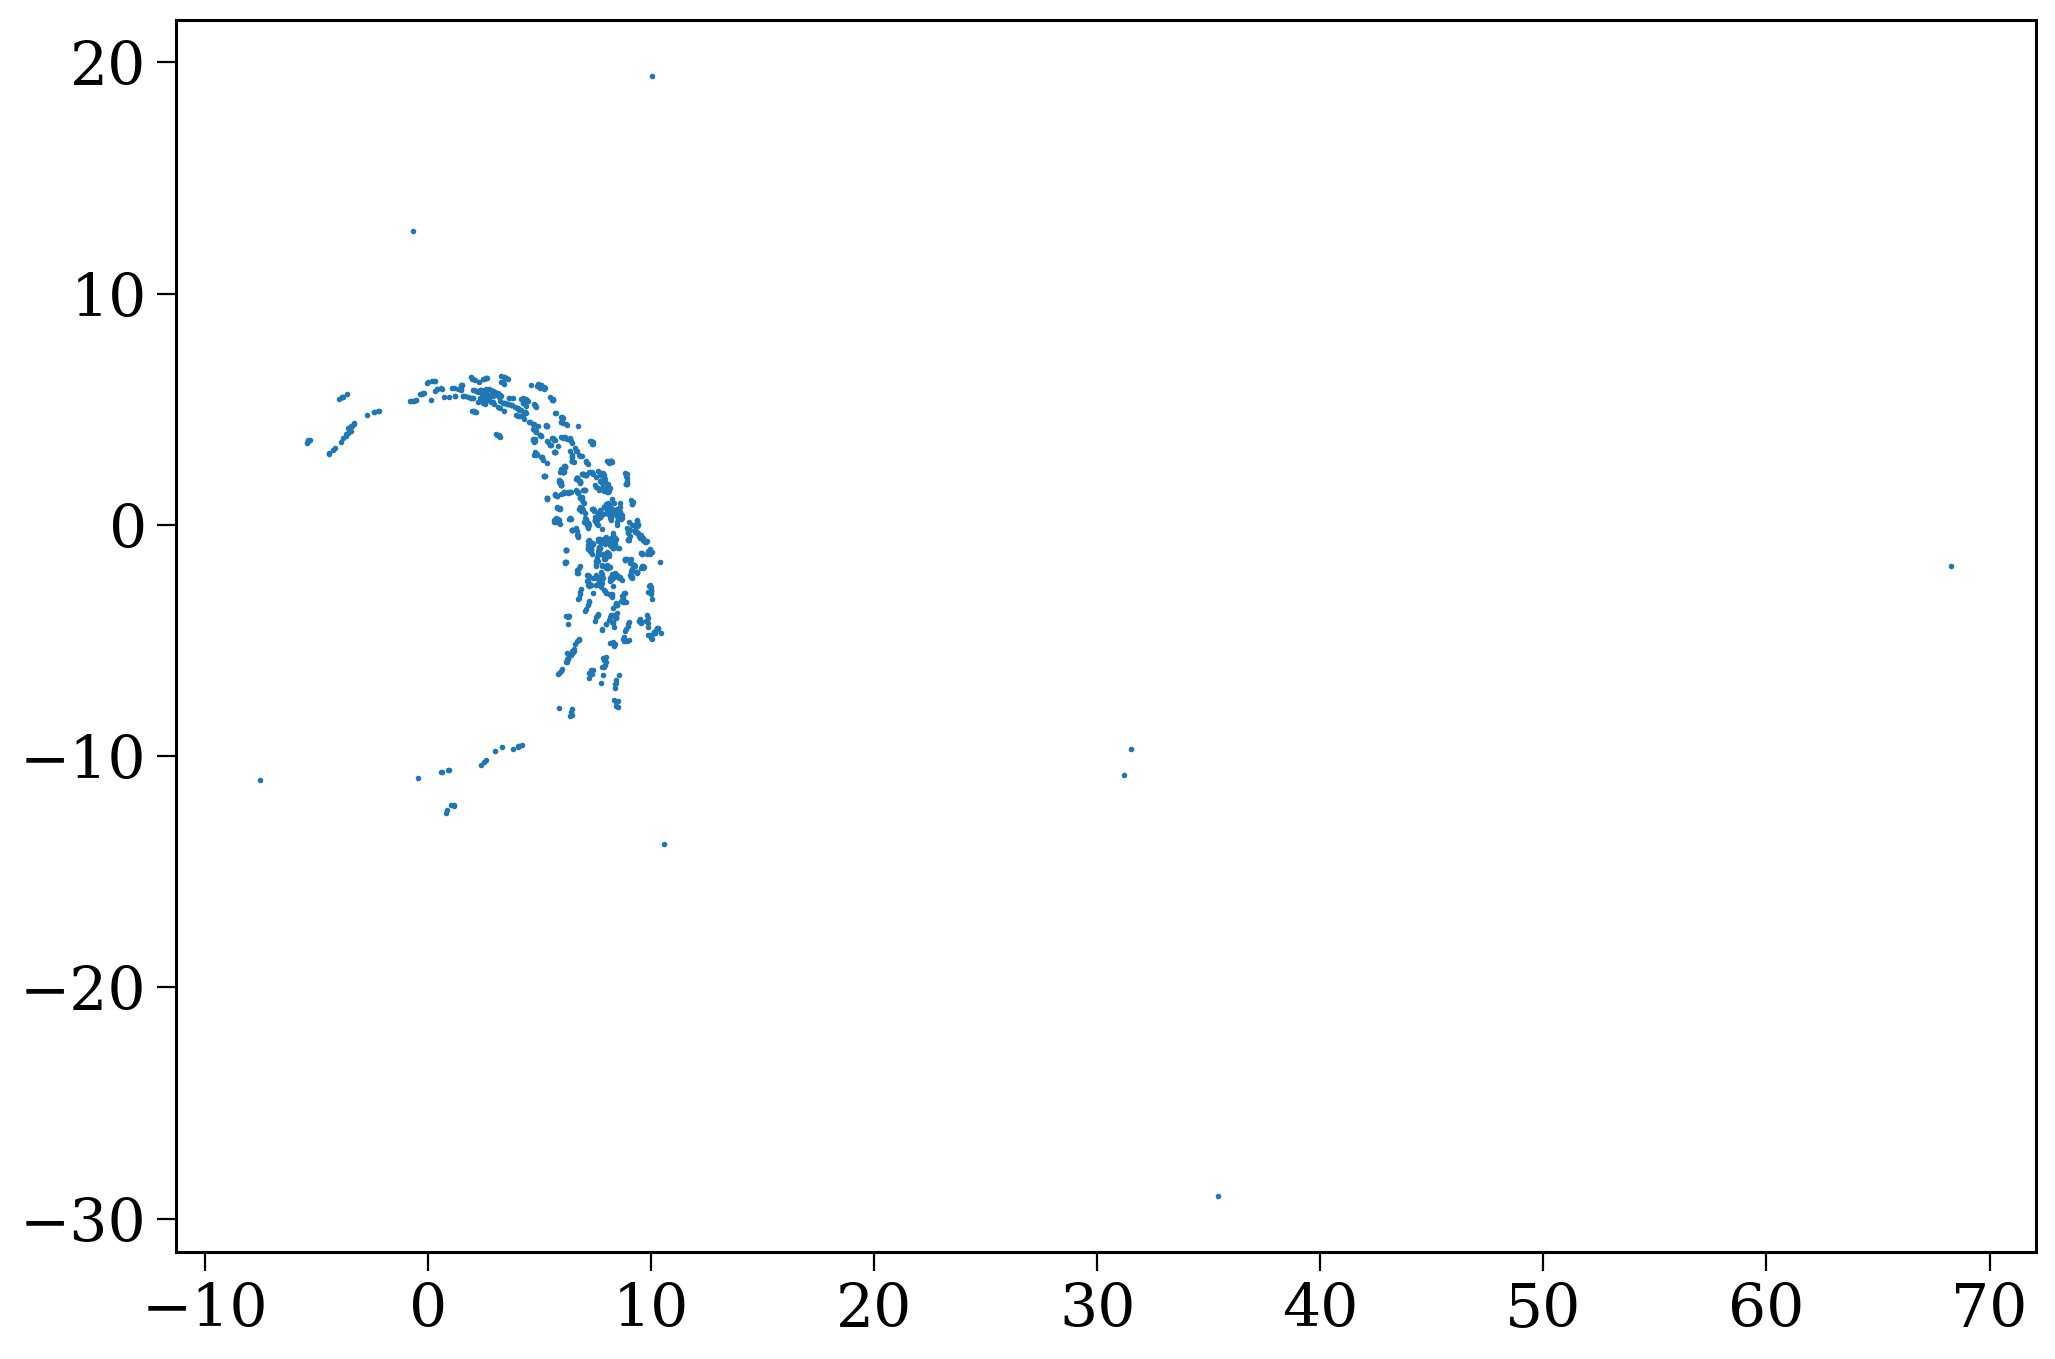

In [10]:
plt.scatter(p.final_pos[:, 0], p.final_pos[:, 1], s=1)

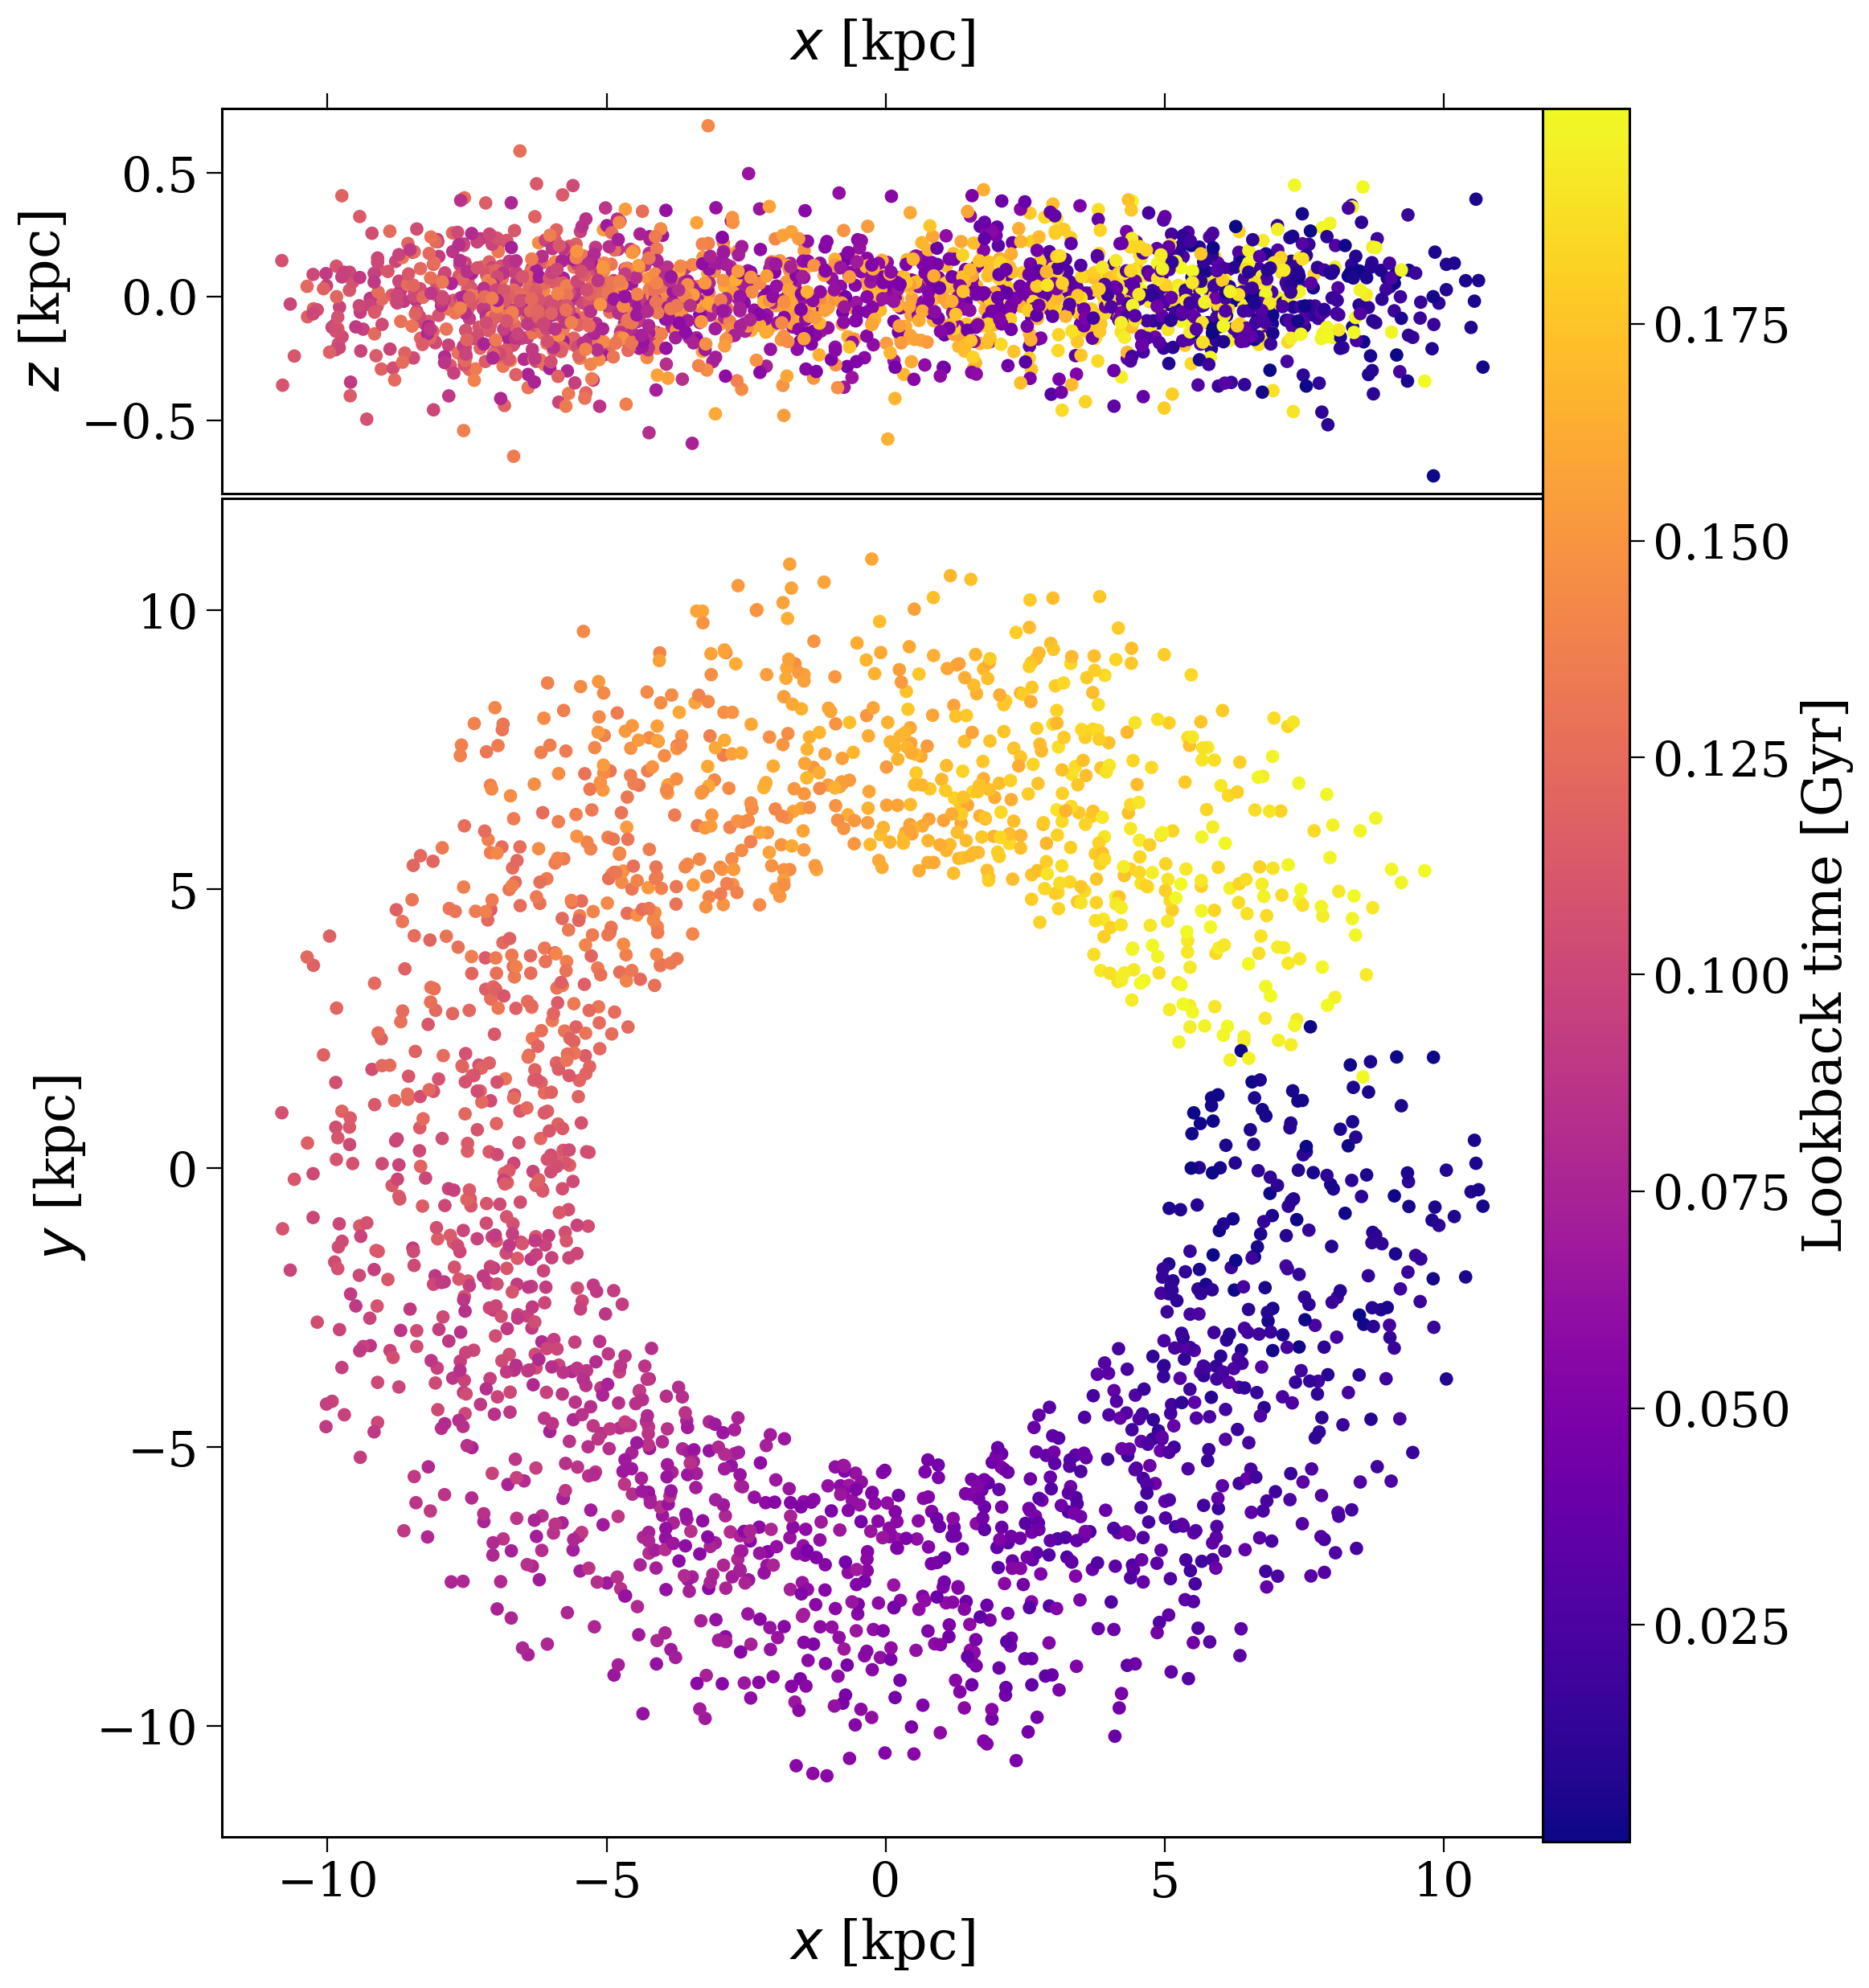

In [ ]:
test._sampled_sfh.plot(colour_by=test._sampled_sfh._tau.value, cbar_norm=None, s=25, cbar_label="Lookback time [Gyr]");

In [ ]:
s2 = ClusteredRecentSB15(size=10000, immediately_sample=True, potential=gp.MilkyWayPotential2022(), verbose=True)

/mnt/home/twagg/codes/gala/src/gala/potential/potential/builtin/special.py:257: GalaFutureWarning: The MilkyWayPotential2022 class will be deprecated soon. Instead, use: MilkyWayPotential(version="v2") to get what is currently the MilkyWayPotential2022 class. Or, to always use the latest Milky Way model in Gala, you can call the class with no arguments MilkyWayPotential() or specify MilkyWayPotential(version="latest")
  warnings.warn(

Setting up Sanders & Binney 2015 star formation history model to work with Agama
Pre-computing lookback time, guiding radius and frequency interpolations
Initiating sampling procedure
  Sampling 10000 stars from the thin_disc
    Sampling 10000 stars with lookback times between 0.00 Gyr and 2.00 Gyr


In [ ]:
s3 = ClusteredRecentSB15(size=100000, immediately_sample=True, potential=gp.MilkyWayPotential2022(), verbose=True)

/mnt/home/twagg/codes/gala/src/gala/potential/potential/builtin/special.py:257: GalaFutureWarning: The MilkyWayPotential2022 class will be deprecated soon. Instead, use: MilkyWayPotential(version="v2") to get what is currently the MilkyWayPotential2022 class. Or, to always use the latest Milky Way model in Gala, you can call the class with no arguments MilkyWayPotential() or specify MilkyWayPotential(version="latest")
  warnings.warn(

Setting up Sanders & Binney 2015 star formation history model to work with Agama
Pre-computing lookback time, guiding radius and frequency interpolations
Initiating sampling procedure
  Sampling 100000 stars from the thin_disc
    Sampling 100000 stars with lookback times between 0.00 Gyr and 2.00 Gyr


In [ ]:
s = s2 + s3

Ignoring extra parameters: dict_keys(['tau_m', 'tau_S', 'tau_T', 'tau_F', 'tau_1', 'galaxy_age', 'v_x', 'v_y'])


Setting up Sanders & Binney 2015 star formation history model to work with Agama
Pre-computing lookback time, guiding radius and frequency interpolations


Ignoring extra parameters: dict_keys(['tau_m', 'tau_S', 'tau_T', 'tau_F', 'tau_1', 'galaxy_age', 'v_x', 'v_y'])


Setting up Sanders & Binney 2015 star formation history model to work with Agama
Pre-computing lookback time, guiding radius and frequency interpolations


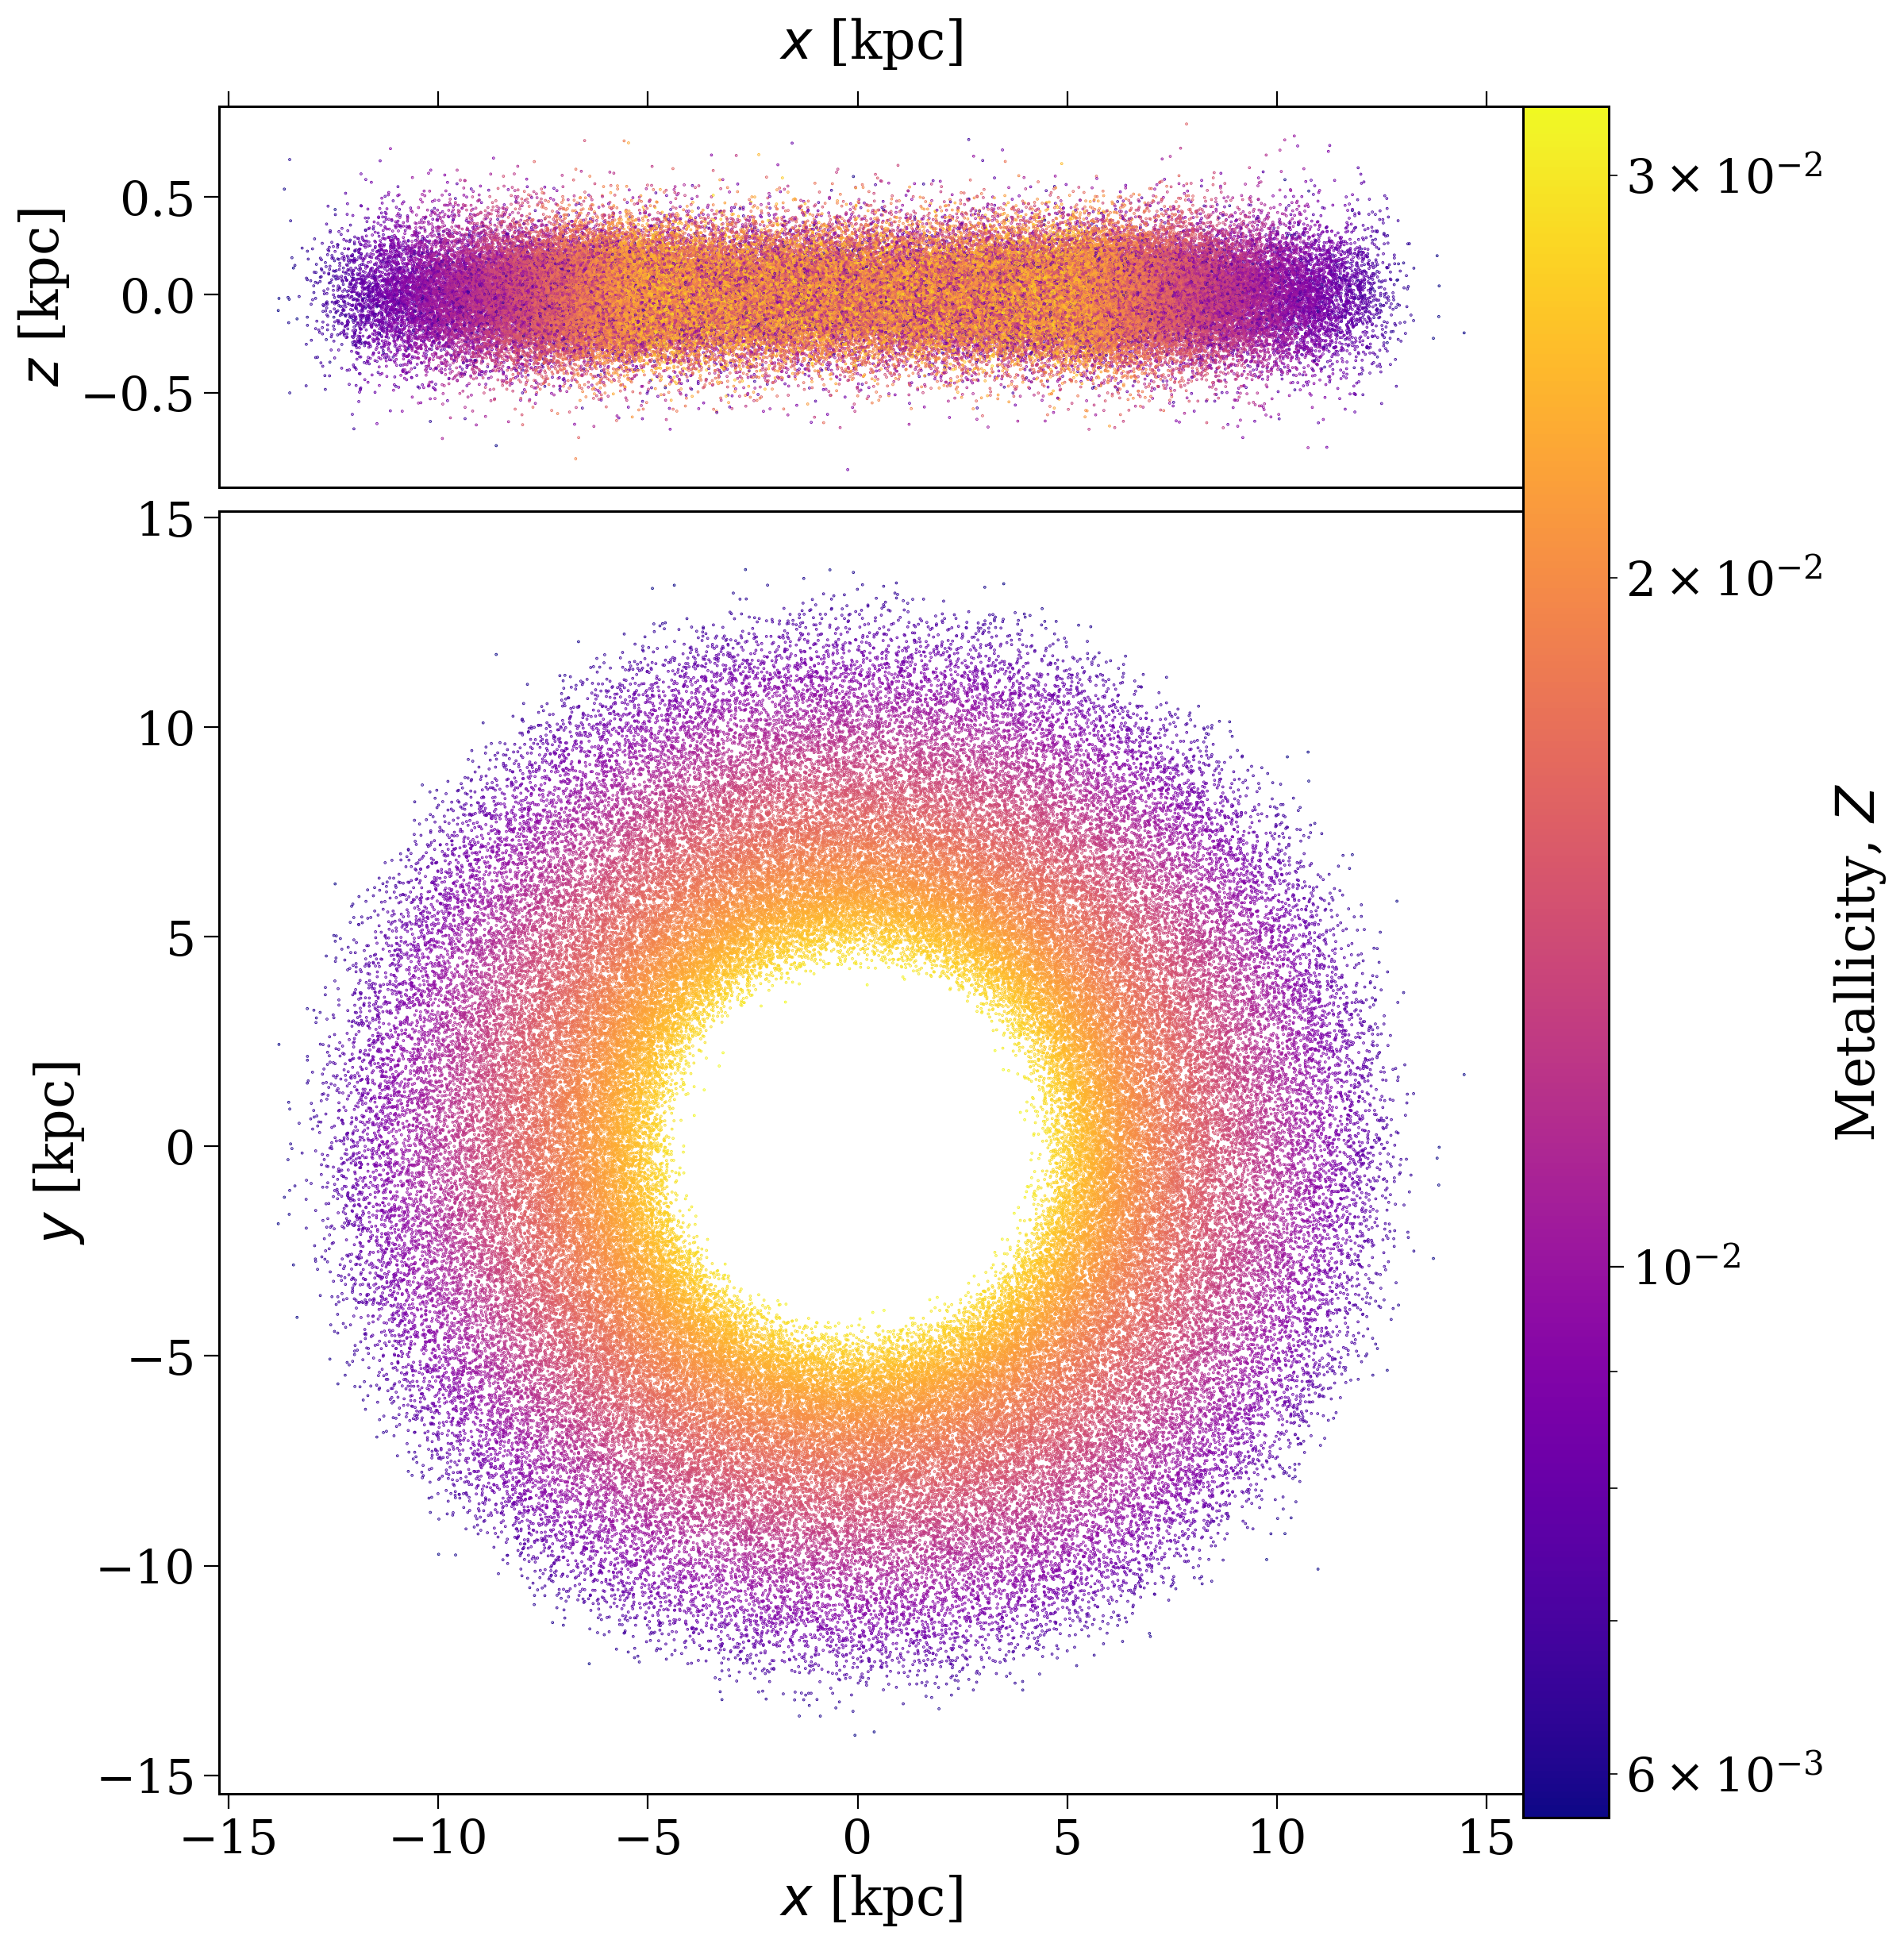

(<Figure size 1247.5x1400 with 3 Axes>,
 array([<Axes: xlabel='$x$ [kpc]', ylabel='$z$ [kpc]'>,
        <Axes: xlabel='$x$ [kpc]', ylabel='$y$ [kpc]'>], dtype=object))

In [ ]:
(s2 + s3).plot()

In [ ]:
sun_x, sun_y = s.sun_pos(-s._tau)
dist = ((sun_x - s.x)**2 + (sun_y - s.y)**2)**(0.5)

In [ ]:
p.initial_galaxy

In [ ]:
3e6 / 1e3

3000.0

In [ ]:
(dist < s.near_thresh).sum()

np.int64(9189)

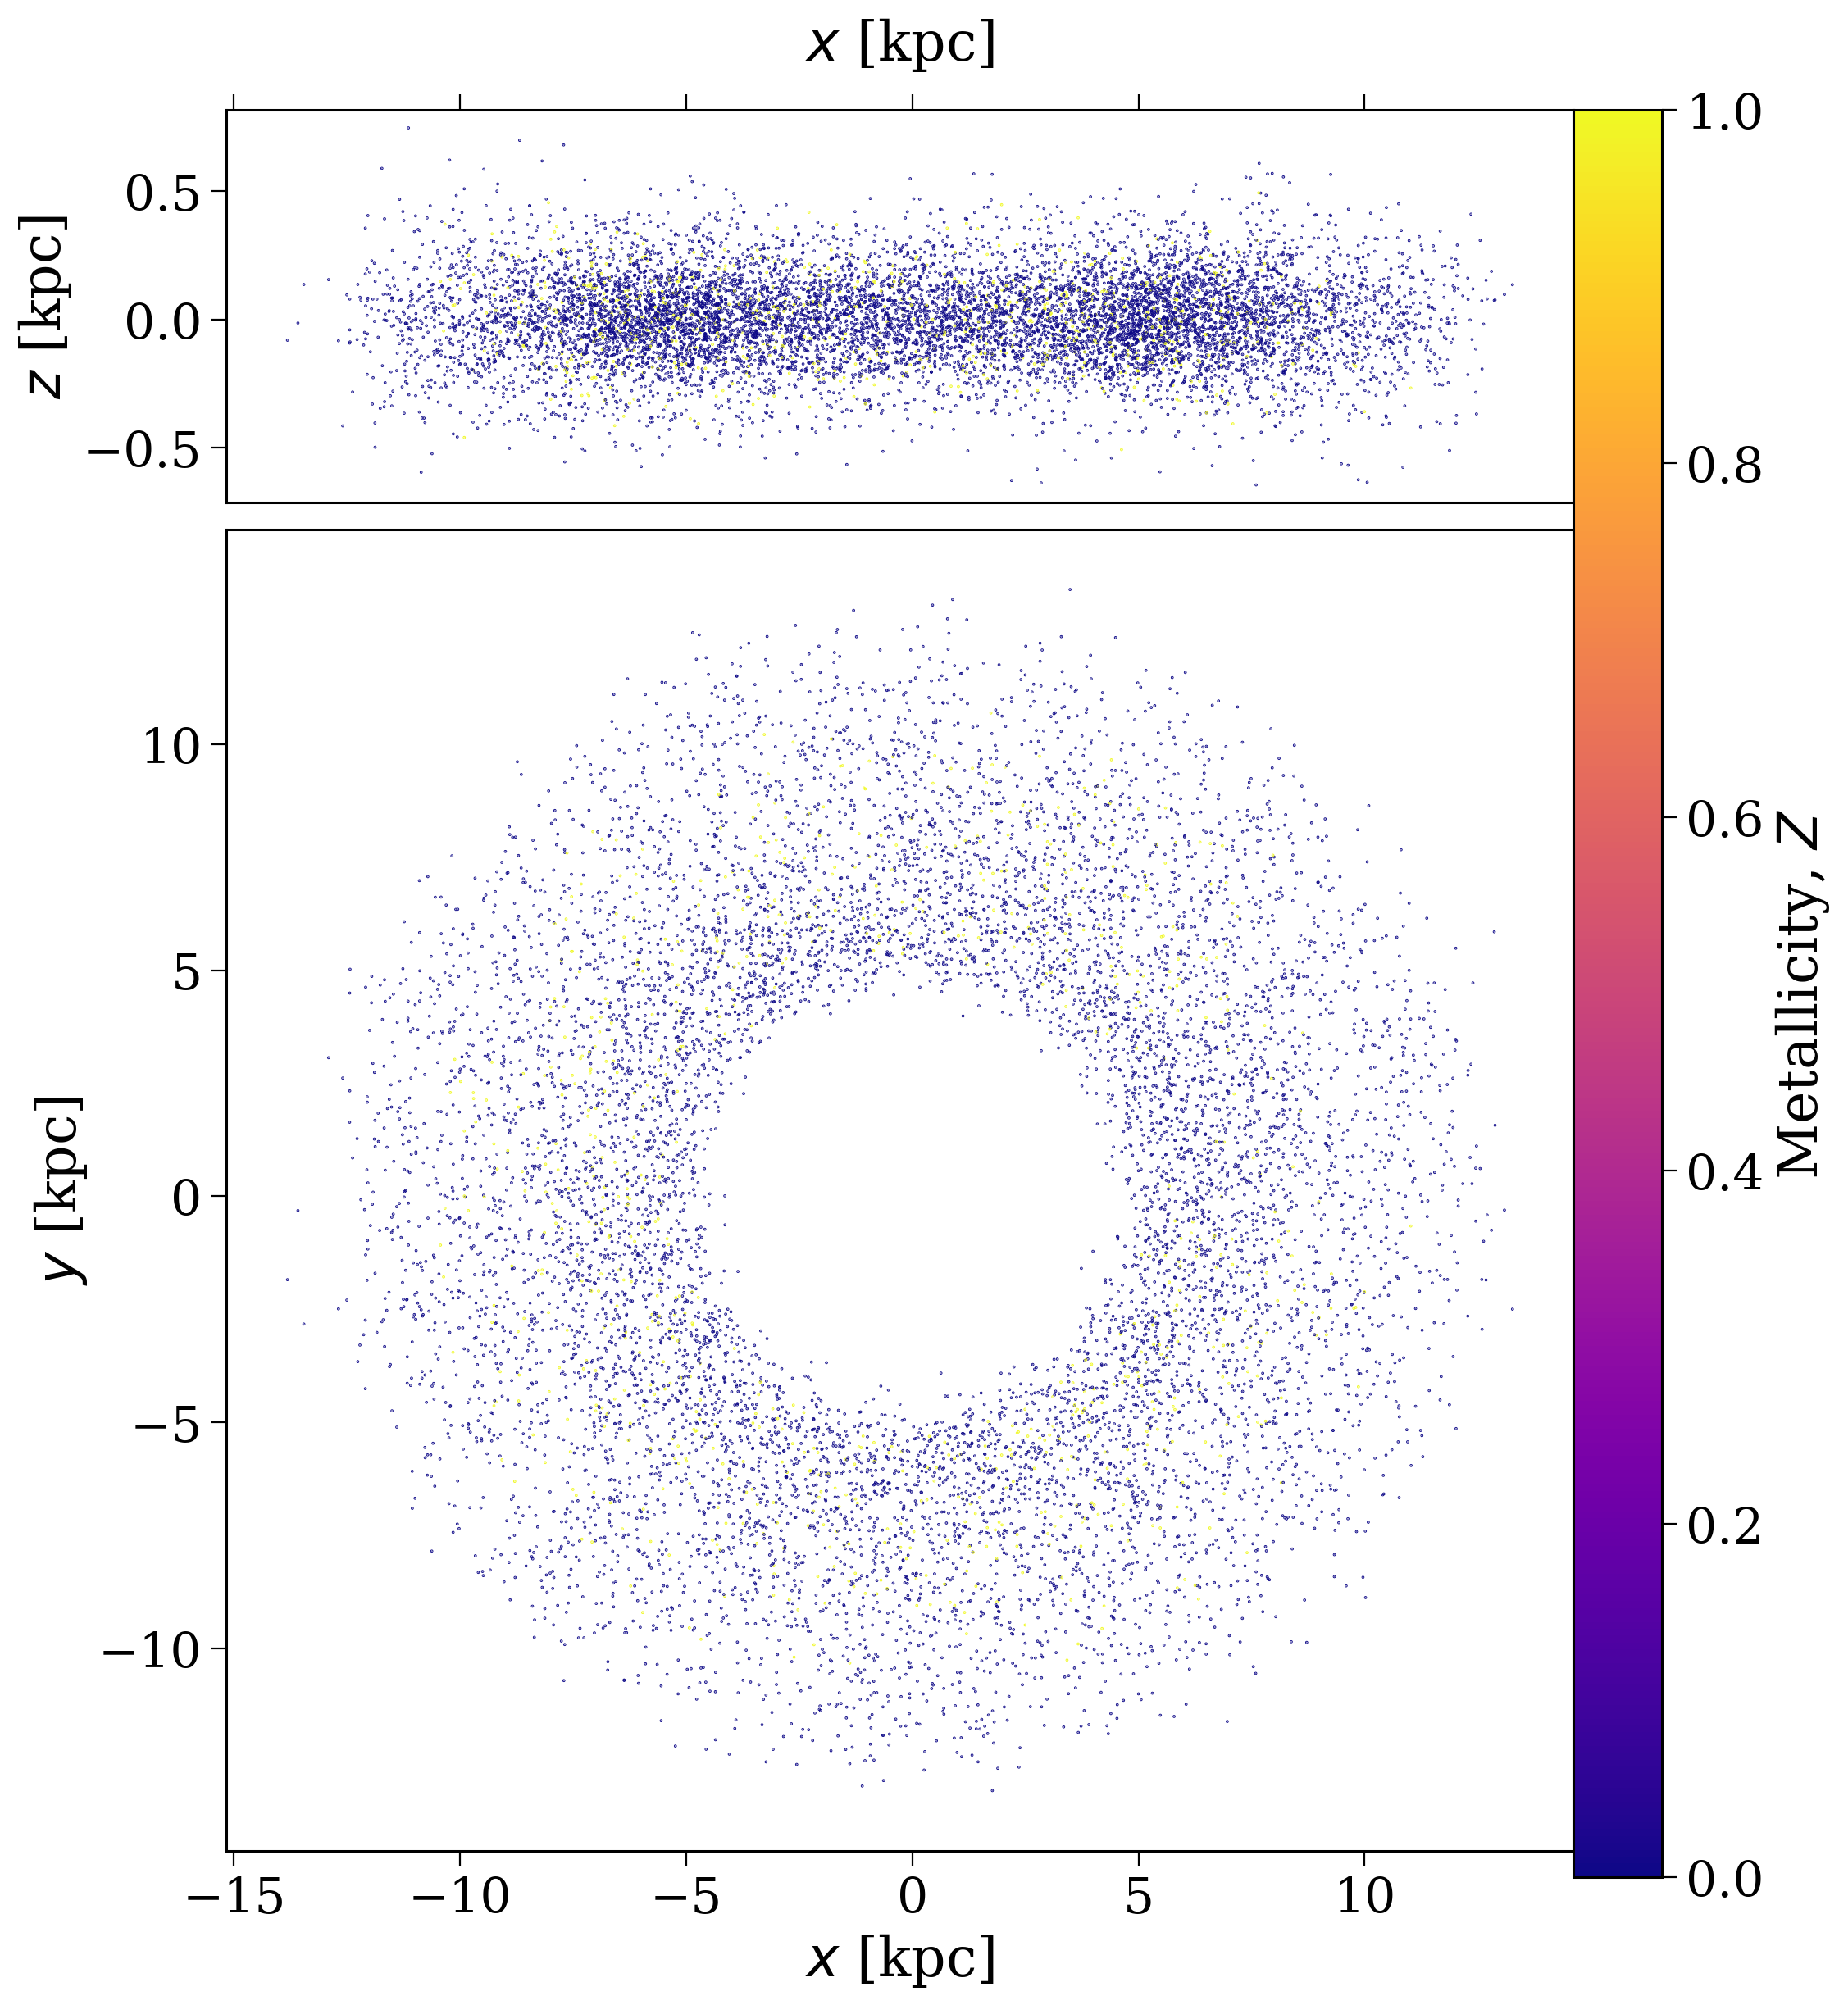

(<Figure size 1247.5x1400 with 3 Axes>,
 array([<Axes: xlabel='$x$ [kpc]', ylabel='$z$ [kpc]'>,
        <Axes: xlabel='$x$ [kpc]', ylabel='$y$ [kpc]'>], dtype=object))

In [ ]:
s2.plot(colour_by=dist.value < 3, cbar_norm=None)

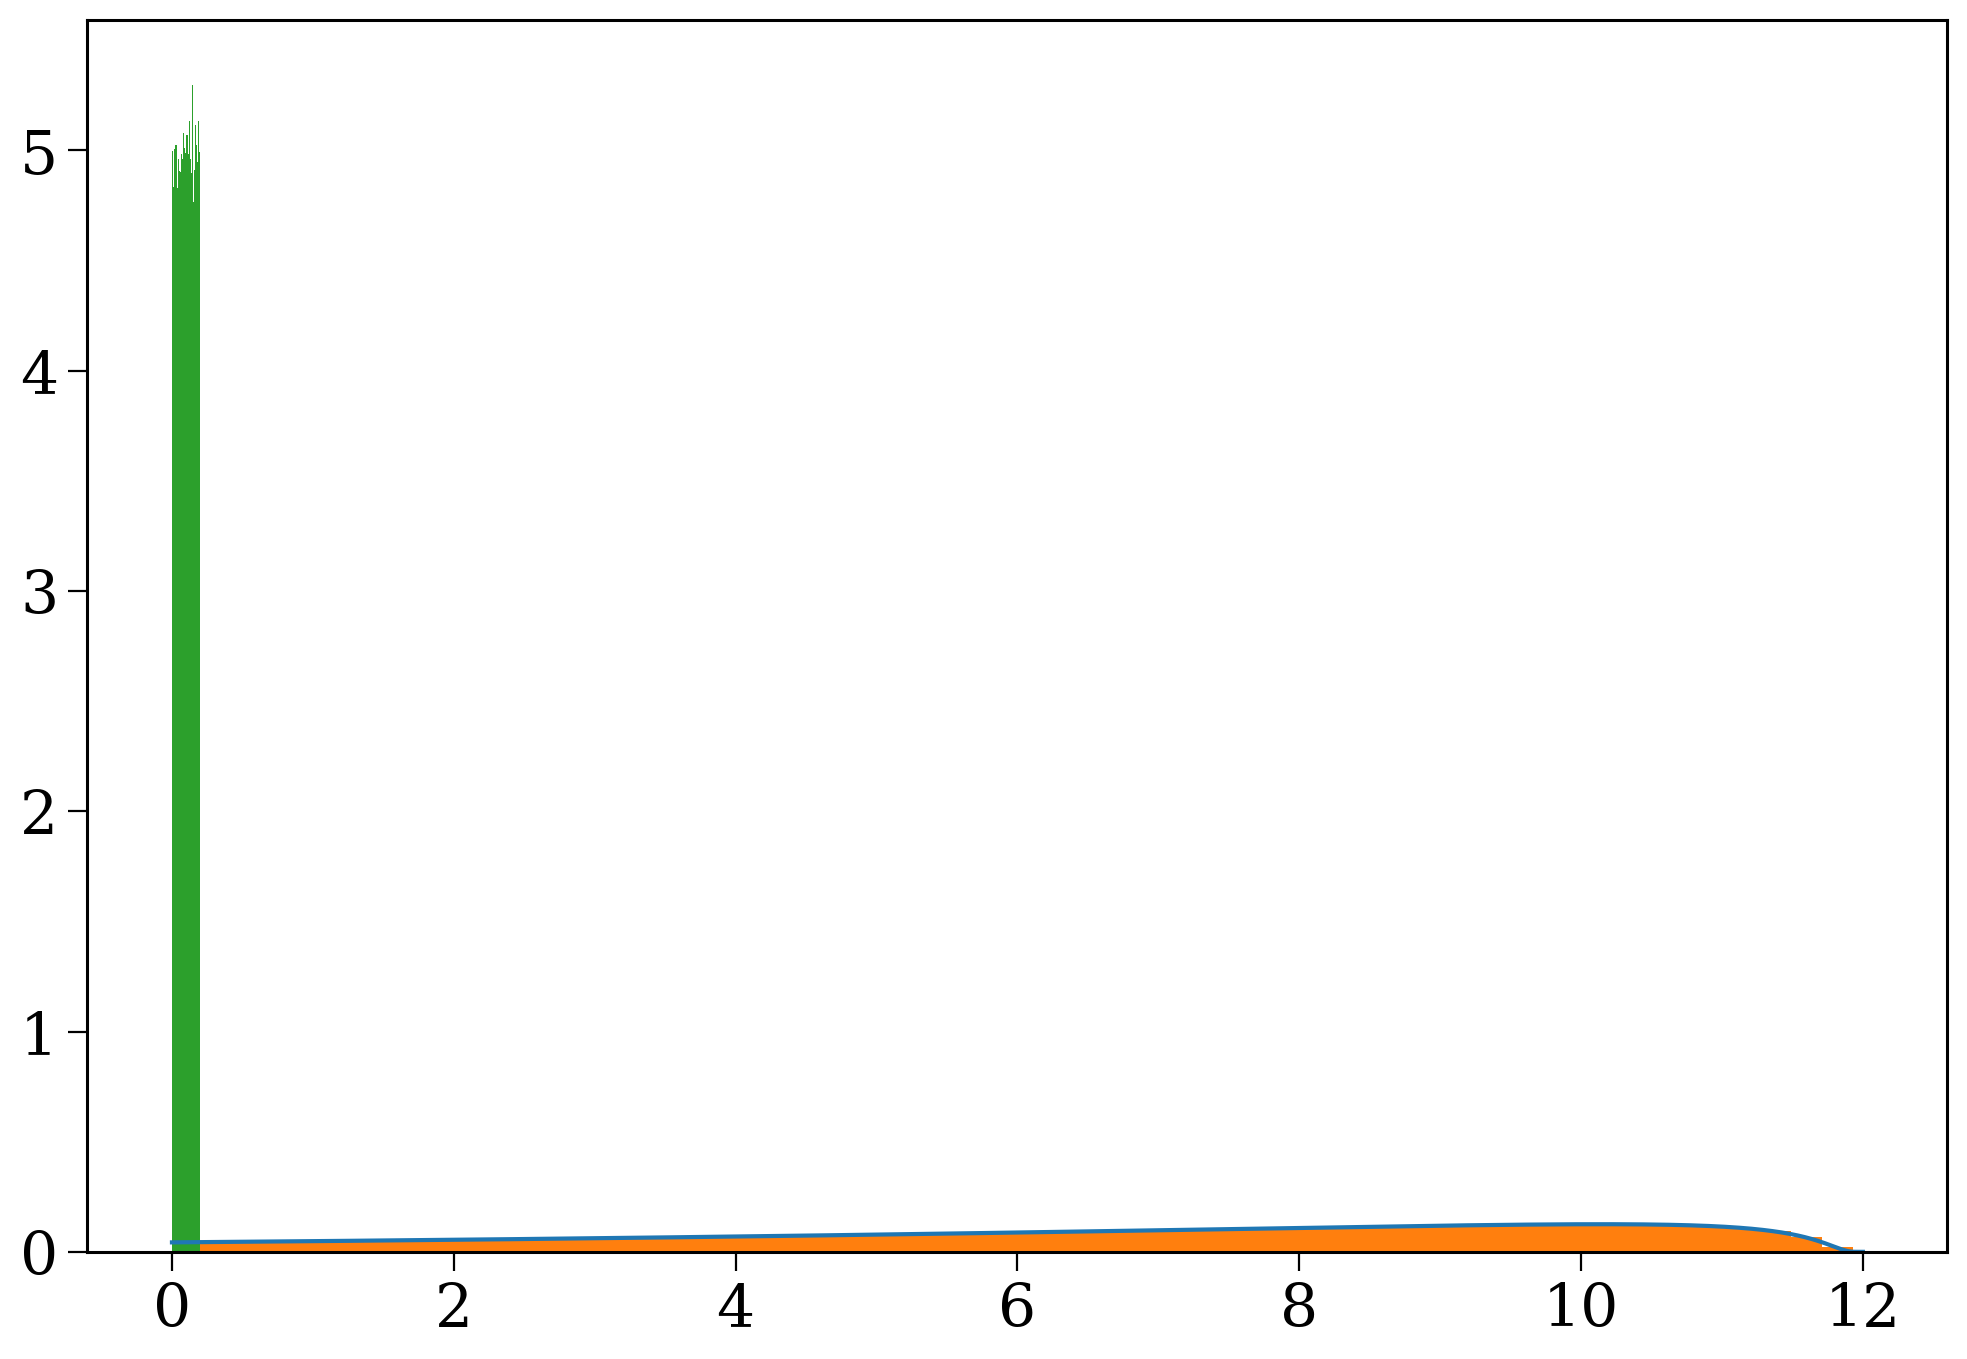

In [ ]:
tau_range = np.linspace(0, 12 - 1e-10, 10000)
pdf = np.exp(tau_range / 8 - .43 / (12 - tau_range))

# normalise pdf
pdf /= np.trapezoid(pdf, tau_range)

plt.plot(tau_range, pdf)
# tau_range = np.linspace(0, .2, 10000)
# pdf = np.exp(tau_range / 8 - .43 / (12 - tau_range))
# plt.plot(tau_range, pdf)
# plt.ylim(0, 3)

plt.hist(s.draw_lookback_times().to(u.Gyr), bins="fd", density=True)
plt.hist(s2.draw_lookback_times().to(u.Gyr), bins="fd", density=True)

plt.show()